In [20]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Results: Pretraining - Finetuning - Classification
#### Cristobal Donoso 
*last updated: 2026-01-10*

In [ ]:
import os
import matplotlib.pyplot as plt
import glob

from presentation.pipelines.pipeline_0.utils import classification_metrics

from src.metrics.visualize import get_sorted_experiments, load_experiment_metrics
from src.utils import tensorboard_logs

from src.plot.training import plot_learning_curves
from src.plot.classification import aggregate_classification_results, plot_f1_scores
from src.plot.finetuning import get_pretrain_baseline, extract_final_metrics_to_df
from src.plot.general import save_plot

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
results_directory = './presentation/results/v2/'
model_paths = glob.glob(os.path.join(results_directory, 'pretraining'))

In [102]:
sorted_path, sorted_labels = get_sorted_experiments(model_paths)
sorted_path

['./presentation/results/v2/pretraining']

### Pretraining

In [94]:
t_metrics, v_metrics = load_experiment_metrics(sorted_path, tensorboard_logs)

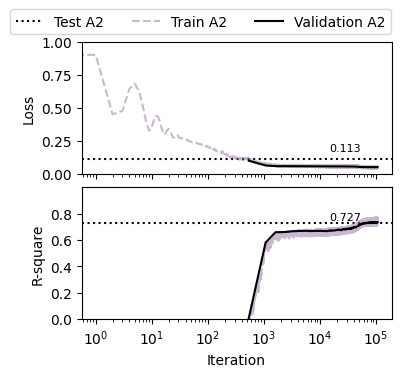

In [103]:
fig, axes = plt.subplots(2, 1, figsize=(4, 3.6), dpi=100, sharex=True, gridspec_kw={'wspace':0.2, 'hspace':0.1})
colormap = ['k', 'gray', 'b', 'g', 'y']

subset_slice = slice(0, 1)

# 4. Generate Plot
fig, axes = plot_learning_curves(
    train_metrics=t_metrics[subset_slice],
    val_metrics=v_metrics[subset_slice],
    paths=sorted_path[subset_slice],
    labels=sorted_labels[subset_slice],
    fig=fig, axes=axes
)

In [56]:
save_plot(fig, './presentation/figures/pretraining/tr_astromer_2.pdf')

Plot saved successfully at: ./presentation/figures/pretraining/tr_astromer_2.pdf


### Finetuning

In [104]:
pt_path = os.path.join(results_directory, 'pretraining')

In [224]:
ft_paths = glob.glob(os.path.join('./presentation/results/v2/finetuning/', '*', '*', '*'))

In [228]:
df_metrics = extract_final_metrics_to_df(ft_paths, tensorboard_logs)

Saltando ./presentation/results/v2/finetuning/alcock/fold_1/alcock_20: No se encontró 'test_metrics.toml'
Saltando ./presentation/results/v2/finetuning/alcock/fold_1/alcock_100: No se encontró 'test_metrics.toml'
Saltando ./presentation/results/v2/finetuning/alcock/fold_1/alcock_500: No se encontró 'test_metrics.toml'
Saltando ./presentation/results/v2/finetuning/alcock/fold_2/alcock_20: No se encontró 'test_metrics.toml'
Saltando ./presentation/results/v2/finetuning/alcock/fold_2/alcock_100: No se encontró 'test_metrics.toml'
Saltando ./presentation/results/v2/finetuning/alcock/fold_2/alcock_500: No se encontró 'test_metrics.toml'
Saltando ./presentation/results/v2/finetuning/alcock/fold_0/alcock_20: No se encontró 'test_metrics.toml'
Saltando ./presentation/results/v2/finetuning/alcock/fold_0/alcock_100: No se encontró 'test_metrics.toml'
Saltando ./presentation/results/v2/finetuning/alcock/fold_0/alcock_500: No se encontró 'test_metrics.toml'
Saltando ./presentation/results/v2/finet

        label  spc    data         mean  std criteria_used
0   ALCOCK 20    1  alcock   0.04932252  0.0          rmse
1  ALCOCK 100    1  alcock   0.07287229  0.0          rmse
2  ALCOCK 500    1  alcock  0.048368644  0.0          rmse
3   ALCOCK 20    2  alcock  0.038638238  0.0          rmse
4  ALCOCK 100    2  alcock   0.04573084  0.0          rmse
5  ALCOCK 500    2  alcock   0.04803893  0.0          rmse
6   ALCOCK 20    0  alcock  0.039286796  0.0          rmse
7  ALCOCK 100    0  alcock  0.054682005  0.0          rmse
8  ALCOCK 500    0  alcock  0.053566627  0.0          rmse
        label  spc   data         mean  std criteria_used
9   ATLAS 100    1  atlas   0.08410793  0.0          rmse
10   ATLAS 20    1  atlas   0.13266721  0.0          rmse
11  ATLAS 500    1  atlas  0.089894906  0.0          rmse
12  ATLAS 100    2  atlas   0.10102426  0.0          rmse
13   ATLAS 20    2  atlas   0.07624574  0.0          rmse
14  ATLAS 500    2  atlas   0.08672565  0.0          rmse
15  

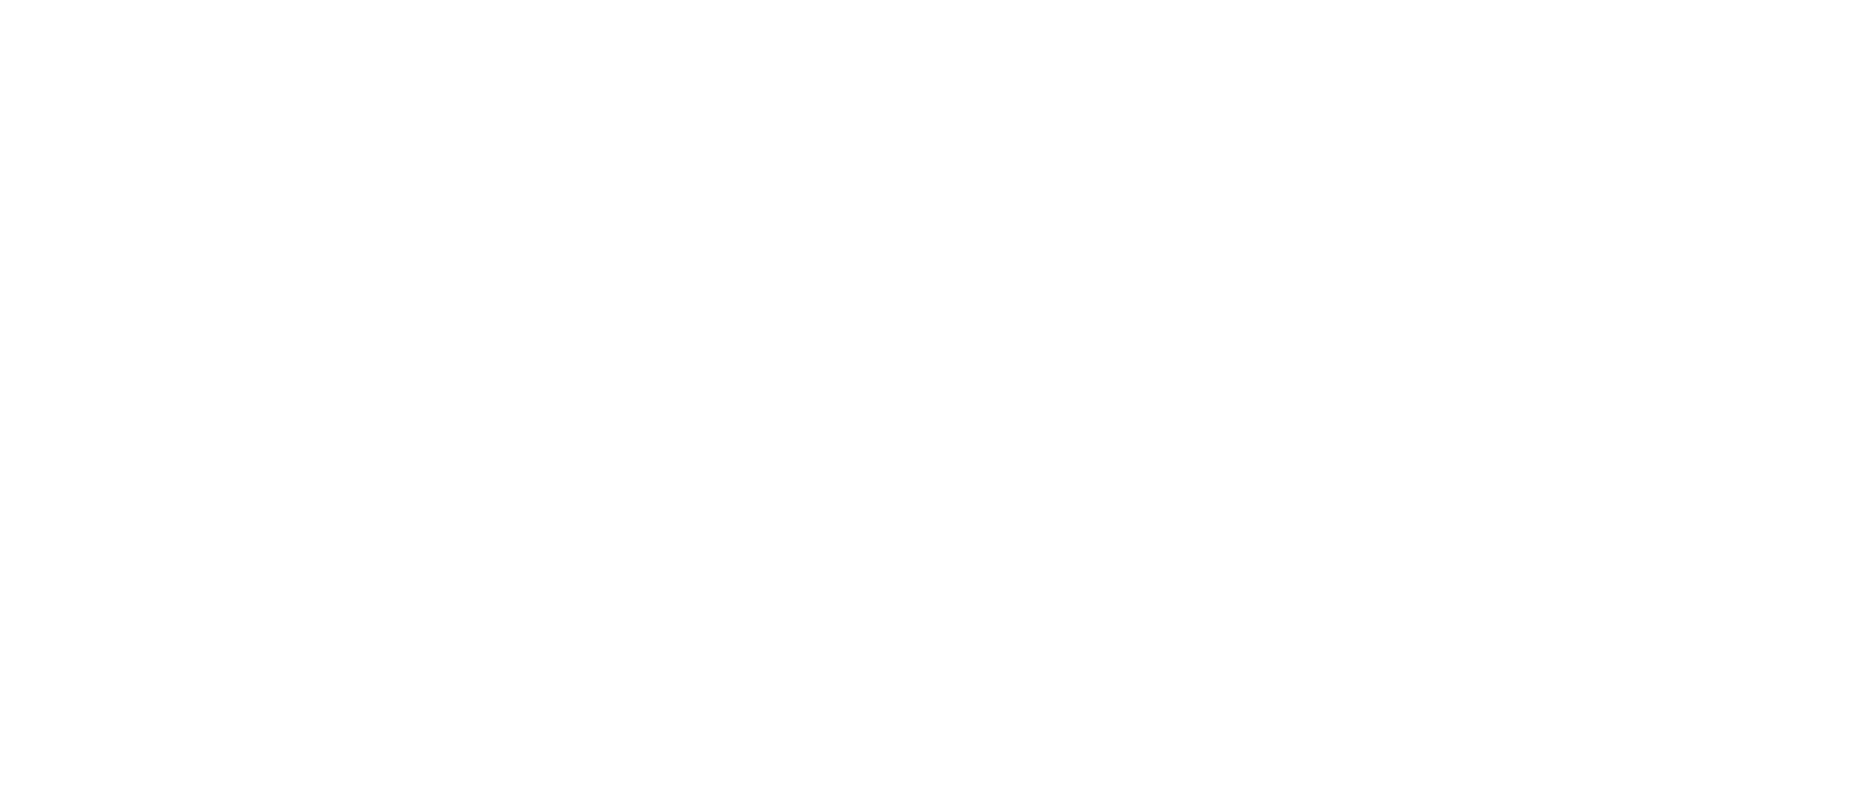

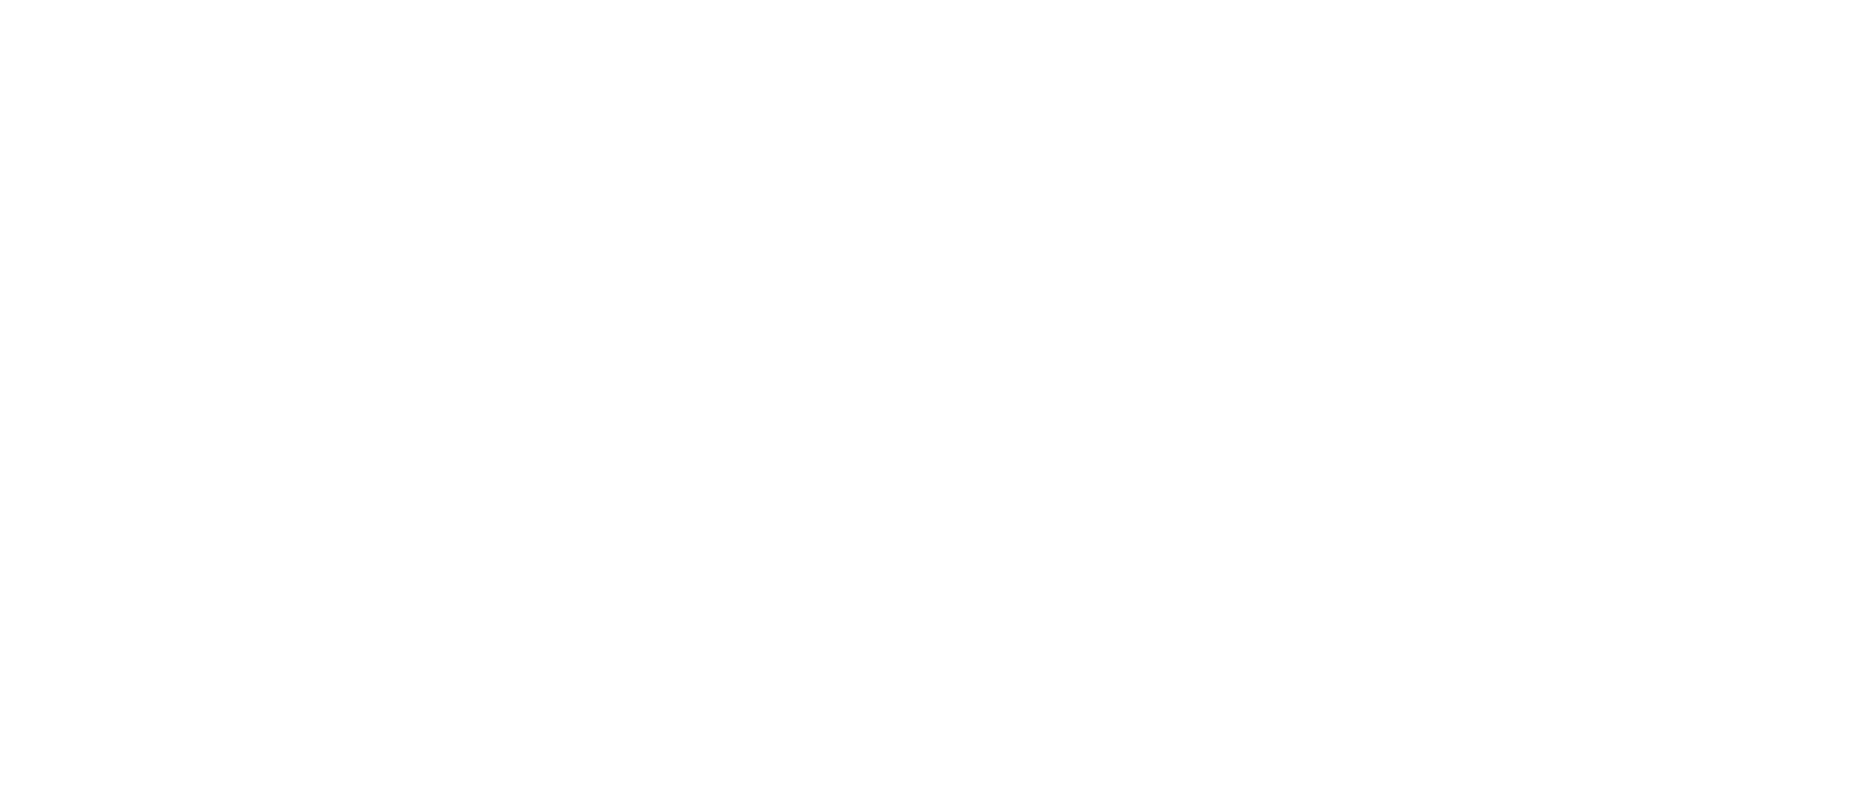

In [147]:
for dataset in ['alcock', 'atlas']:
    df_subset = df_metrics[df_metrics['data'] == dataset]
    print(df_subset)
    if df_subset.empty: continue
        
    fig, axes = plt.subplots(1, 3, figsize=(6, 2.5), sharey=True, dpi=300, 
                             gridspec_kw={'wspace': 0.07})
    fig, axes = plot_ft(
            df=df_subset, 
            dataset_name=dataset, 
            metric_name='Validation Loss',
            pretrain_val=pt_baseline,
            ylim=(0, 1.0), # Ajusta según tus valores de Loss
            fig=fig, 
            axes=axes
        )
# save_plot(fig, './presentation/figures/pretrain_vs_finetune_comparison.pdf')

### Classification

In [59]:
RESULTS_DIR = './presentation/results/v1/'
PLOT_CONFIG = {
    'v2': {
        'ylim': {'alcock': (0.45, 0.8), 'atlas': (0.45, 0.85)},
        'figsize': (6, 2)
    }
}
current_config = PLOT_CONFIG.get(TAG, {'ylim': {'alcock':(0,1), 'atlas':(0,1)}, 'figsize':(6,2)})

# Definitions for baselines (Paper vs New)
baselines = [
    {'path': RESULTS_DIR, 'label': 'Donoso\net.al\n(2023)', 'arch': 'avg_mlp'},
    {'path': RESULTS_DIR, 'label': 'A1', 'arch': 'skip_avg_mlp'}
]

# --- 2. Data Loading ---
# We use the loader function we created to merge everything cleanly
full_metrics_df = aggregate_classification_results(
    baseline_paths=baselines,
    experiment_paths=sorted_path, # Using your slicing logic
    experiment_labels=sorted_labels,
    metric_loader_func=classification_metrics
)

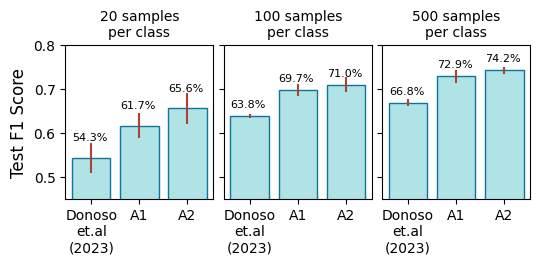

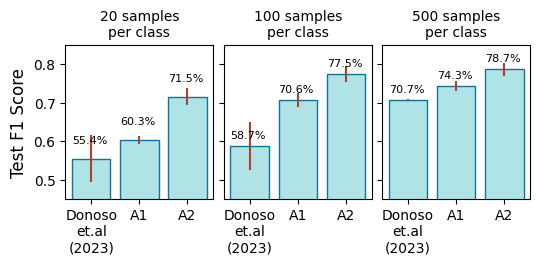

In [61]:
for dataset_name, df_subset in full_metrics_df.groupby('data'):
    
    # Get Y-limits specific to this dataset (alcock/atlas)
    y_limits = current_config['ylim'].get(dataset_name, (0, 1))
    
    # Create Figure
    fig, axes = plt.subplots(1, 3, figsize=current_config['figsize'], 
                             sharey=True, dpi=100, gridspec_kw={'wspace': 0.07})
    
    # Plot
    plot_f1_scores(
        df=df_subset,
        dataset_name=dataset_name,
        ylim=y_limits,
        fig=fig,
        axes=axes
    )
    